In [1]:
import pickle
import pandas as pd
import numpy as np
import math
import scipy.fftpack
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from tqdm import tqdm

In [14]:
class Environment():
    ### environment variables
    ### convert the pixel width (832) in [mm] --> environment = 38[mm]x38[mm]
    def __init__(self, bool_save = False):
        self.enivronment_size = 38
        self.nb_pixel = 832
        self.position_convert = self.enivronment_size/self.nb_pixel
        self.stim_legend = ["stimulation off", "stimulation on"]
        self.color_plot = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:brown']
        self.color_stim = ['r', 'b']
        self.figure_size = [8, 6]
        self.dpi = 300
        self.bool_save = bool_save
        self.plot_lim = [-38, 38]

class Fly_Experiment():

    def __init__(self, name):
        self.name = name

    def general_info(self, simulation = 'MDN', folder = '200206_110534_s1a10_p3-4', index_folder = 0, frame_split = [],\
                     nb_fly = 0, frame_per_fly = 0, frame_per_period = None, \
                     frame_per_period_tot = None, frame_frequency = 80): #, x_pos = None, y_pos = None) :

        self.simulation = simulation
        self.folder = folder
        self.split_name_fodler = self.folder[:13]
        self.frame_split = frame_split
        self.index_folder = index_folder
        self.nb_fly = nb_fly
        self.frame_per_fly = frame_per_fly
        self.frame_per_period = frame_per_period
        self.frame_per_period_tot = frame_per_period_tot
        self.total_frame = frame_per_period_tot[-1]
        self.frame_frequency = frame_frequency

    def index_order(self, index):
        self.index = index

    def position_order(self, x_pos, y_pos, orientation = None):
        self.x_pos = x_pos
        self.y_pos = y_pos
        if orientation.any() :
            self.orientation_order(orientation)

    def orientation_order(self, orientation):
        self.orientation = orientation

    def position_n_order(self, x_pos_n, y_pos_n, orientation_n = None):
        self.x_pos_n = x_pos_n
        self.y_pos_n = y_pos_n
        if orientation_n.any() :
            self.orientation_n_order(orientation_n)

    def orientation_n_order(self, orientation_n):
        self.orientation_n = orientation_n


    def position(self, x_pos, y_pos):
        self.x = x_pos
        self.y = y_pos

In [3]:
def general_data(first_layer) :
# =============================================================================
#     first_layer = 0
#     second_layer = 0
# =============================================================================
    #find the right path for the .pkl and .npy
    simulation = ['MDN', 'PR', 'SS01049', 'SS01054', 'SS01540', 'SS02111', 'SS02279', 'SS02377', 'SS02608', 'SS02617']

    data_path = ['../CoBar-Dataset/']
    data_path.append(simulation[first_layer])
    data_path.append('/U3_f/')
    data_path.append(simulation[first_layer])
    data_path.append('_U3_f_trackingData.pkl')
    data_path = ''.join(data_path)
    "output : '../CoBar-Dataset/MDN/U3_f/MDN_U3_f_trackingData.pkl'"

    gen_path = ['../CoBar-Dataset/']
    gen_path.append(simulation[first_layer])
    gen_path.append('/U3_f/genotype_dict.npy')
    gen_path = ''.join(gen_path)
    "output : '../CoBar-Dataset/MDN/U3_f/genotype_dict.npy'"


    genDict = np.load(gen_path, allow_pickle=True).item()

    with open(data_path, 'rb') as f:
        data = pickle.load(f)

    "there is an error in SS02608 '200212_155556_s3a8_p3-4' some posy data are far away from reality "
    if first_layer == 8 :
        for i in range(0,9):
            wrong_data = 7638
            true_data = wrong_data - 1
            data[('center', 'posy')][wrong_data + i] = data[('center', 'posy')][true_data]


    ### store the name of the different folder in all_folder
    all_folder = []

    for key, _ in genDict.items() :
        all_folder.append(key)
    """ output : all_folder = ['200206_110534_s1a10_p3-4', '200206_160327_s4a9_p3-4', '200206_105311_s1a9_p3-4', '200206_153954_s4a10_p3-4']"""

    return genDict, data, all_folder, simulation[first_layer]

In [10]:
def experiment_center_pos(genDict, data, environment, all_folder, simulation, second_layer):

    """index correspond to the right index of all flies and all sequences for a specific experiment"""
    index = np.array([])
    experiment = experiment_propeties(genDict, data, environment,
                                      all_folder, simulation, second_layer)

    for i, frame in enumerate(experiment.frame_per_period):

        idx_tmp = []

        #find the index of the starting "on/off" period for each fly
        for j in range(0,experiment.nb_fly):

            index_fly = experiment.frame_per_fly*j
            index_stim = np.where(np.array(data.reset_index().iloc[(experiment.index_folder + index_fly): ,1])\
                                  == experiment.frame_split[i])[0][0]
            index_stim += experiment.index_folder + index_fly
            idx_tmp = np.append(idx_tmp, np.arange(index_stim, (index_stim + frame)))

        idx_tmp = idx_tmp.reshape(experiment.nb_fly, frame)
        index = np.hstack([index, idx_tmp]) if index.size else idx_tmp
        index = index.astype(int)

    experiment.index_order(index)

    x_pos, y_pos = any_coordinates(experiment, data.center.posx, data.center.posy)
    orientation = angle_coordinates(experiment, data.center.orientation)

    x_pos_n, y_pos_n = any_coordinates(experiment, data.center.posx_n, data.center.posy_n)
    orientation_n = angle_coordinates(experiment, data.center.orientation_n)

    experiment.position_order(x_pos, y_pos, orientation)
    experiment.position_n_order(x_pos_n, y_pos_n, orientation_n)

    return experiment

In [12]:
def experiment_propeties(genDict, data, environment, all_folder, simulation, second_layer):

    ### pick one specific folder
    folder = all_folder[second_layer]
    split_name_fodler = folder[:13]
    """output : '200206_110534'"""

    ### Find the first element of the folder (experiment) in the DataFrame
    index_folder = np.where(np.array(data.reset_index().iloc[:,3]) == split_name_fodler)[0][0]

    # =============================================================================
    # data2 = data.reset_index()
    # data3 = data2.iloc[:,3]
    # data3 = np.array(data3)
    # np.where(data3 =="200206_160327")[0][0]
    # =============================================================================


    ###  extract the nuber of frames per video and per sequence on/off
    frame_split = genDict[folder]['stimulation_paradigm']
    frame_per_period = []
    frame_per_period_tot = [0]
    third_layer = []

    for key, _ in genDict[folder].items() :
            third_layer.append(key)
            "third_layer[2] is always the first fly, could be fly1 if fly0 doesn't exist"

    for _, split in enumerate(frame_split) :
        frame_per_period.append(genDict[folder][third_layer[2]][split]['nb frames'])
        frame_per_period_tot.append(sum(frame_per_period))
    """ output : frame_per_period     = [38, 234, 793, 240, 798, 240, 47]
        output : frame_per_period_tot = [0, 38, 272, 1065, 1305, 2103, 2343, 2390]"""


    ### number of fly and frame per fly
    nb_fly = len(genDict[folder].keys()) - 2
    frame_per_fly = frame_per_period_tot[-1]
    frame_frequency = genDict[all_folder[second_layer]]['fps']

    ### insert all values in a class
    experiment = Fly_Experiment(second_layer)
    experiment.general_info(simulation, folder, index_folder, frame_split, nb_fly, \
                            frame_per_fly, frame_per_period, \
                            frame_per_period_tot, frame_frequency)

    return experiment

In [16]:
#%%
def any_coordinates(experiment, x_coordinate, y_coordinate):

    x_pos = x_coordinate.values[experiment.index] * environment.position_convert
    y_pos = y_coordinate.values[experiment.index] * environment.position_convert

    return x_pos, y_pos

#%%
def angle_coordinates(experiment, theta_coordinate):

    theta_pos = theta_coordinate.values[experiment.index]

    return theta_pos

In [35]:
def joint_normalized(exp, x_pos_all, y_pos_all, x_pos_joint, y_pos_joint) :

# =============================================================================
#     x_pos_joint = x_pos_joint - exp.x_pos
#     y_pos_joint = y_pos_joint - exp.y_pos
# =============================================================================

    """ reshape x_pos_all ti have (3, :)"""
    # x_pos_all = np.append(x_pos_all, x_pos_joint)
    # x_pos_all = np.concatenate(x_pos_all, x_pos_joint)
    x_pos_all = np.hstack([x_pos_all, x_pos_joint]) if x_pos_all.size else x_pos_joint

    # y_pos_all = np.append(y_pos_all, y_pos_joint)
    # y_pos_all = np.concatenate(y_pos_all, y_pos_joint)
    y_pos_all = np.hstack([y_pos_all, y_pos_joint]) if y_pos_all.size else y_pos_joint



    return x_pos_all, y_pos_all

In [74]:
def joint_position_over_time(genDict, data, all_experiment, all_folder, fly_number = 0):

# =============================================================================
#     """ to extract x and y position of any data.keys(),
#         example : Leye.x, Rantenna.y"""
# =============================================================================

    k = fly_number
    color = environment.color_plot
    step = 1
    legend = []
    genDict_key = []
    stim_key = genDict[all_experiment[0].folder]['stimulation_paradigm']
    legend = ["Left Fore", "Left Middle", "Left Hind", "Right Fore", "Right Middle", "Right Hind"]
    # legend = ["Left fft", "Left", "Right fft", "Right"]
    x_plot_interval = [0, -0.5, -1.5, 0, 0.5, 1.5]
    x_plot_interval_fft = [-0.5, -1, -1.5, 0.5, 1, 1.5]
    y_plot_interval_fft = [0, 0.5, 1, 0, 0.5, 1]

    for key, value in genDict[all_experiment[0].folder].items() :
        genDict_key.append(key)
    
    pos_data = []
    time_data = []

    for i in range(len(all_experiment)) :
    # for i in range(0,1) :
        exp = all_experiment[i]

        #plot x and y coordinates of the pretarsus

        x_pos_all = np.array([])
        y_pos_all = np.array([])
        time = np.arange(0,int(exp.total_frame/step))/exp.frame_frequency

        """ extracting all the joint positions """
        x_pos_LF, y_pos_LF = any_coordinates(exp, data.LFclaw.x, data.LFclaw.y)
        #x_pos_all, y_pos_all = joint_normalized(exp, x_pos_all, y_pos_all, x_pos_LF, y_pos_LF)

        x_pos_LM, y_pos_LM = any_coordinates(exp, data.LMclaw.x, data.LMclaw.y)
        #x_pos_all, y_pos_all = joint_normalized(exp, x_pos_all, y_pos_all, x_pos_LM, y_pos_LM)

        x_pos_LH, y_pos_LH = any_coordinates(exp, data.LHclaw.x, data.LHclaw.y)
        #x_pos_all, y_pos_all = joint_normalized(exp, x_pos_all, y_pos_all, x_pos_LH, y_pos_LH)

        x_pos_RF, y_pos_RF = any_coordinates(exp, data.RFclaw.x, data.RFclaw.y)
        #x_pos_all, y_pos_all = joint_normalized(exp, x_pos_all, y_pos_all, x_pos_RF, y_pos_RF)

        x_pos_RM, y_pos_RM = any_coordinates(exp, data.RMclaw.x, data.RMclaw.y)
        #x_pos_all, y_pos_all = joint_normalized(exp, x_pos_all, y_pos_all, x_pos_RM, y_pos_RM)

        x_pos_RH, y_pos_RH = any_coordinates(exp, data.RHclaw.x, data.RHclaw.y)
        #x_pos_all, y_pos_all = joint_normalized(exp, x_pos_all, y_pos_all, x_pos_RH, y_pos_RH)
        
        x_pos_all = np.stack((x_pos_LF, x_pos_LM, x_pos_LH, x_pos_RF, x_pos_RM, x_pos_RH), axis=1)
        
        y_pos_all = np.stack((y_pos_LF, y_pos_LM, y_pos_LH, y_pos_RF, y_pos_RM, y_pos_RH), axis=1)
        
        pos_data.append([x_pos_all, y_pos_all])
        time_data.append(time)
    return pos_data, time_data

In [58]:
first_layer = 0
second_layer = 0
normalized = 0
bool_save = True
all_experiment = []


environment = Environment(bool_save = bool_save)

In [59]:
genDict, data, all_folder, simulation = general_data(first_layer)

In [60]:
for i in range(4):
    second_layer = i
    experiment = experiment_center_pos(genDict, data, environment, all_folder, simulation, second_layer)
    all_experiment.append(experiment)

In [107]:
k = 0
pos_data, time_data = joint_position_over_time(genDict, data, all_experiment, all_folder, fly_number = k)

In [110]:
xp_idx = 2

test_y = pos_data[xp_idx][1]
test_time = time_data[xp_idx]
xp = all_experiment[xp_idx]
test_y.shape

(3, 6, 2400)

In [113]:
xp.frame_frequency

80

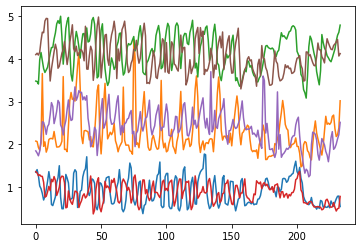

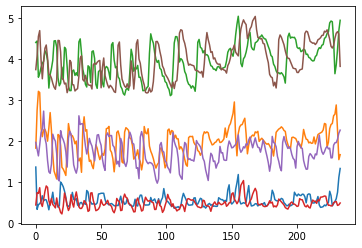

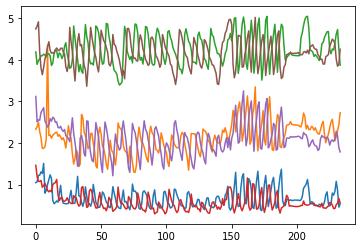

In [112]:
for j in range(test_y.shape[0]):
    plt.figure()
    for i in range(test_y.shape[1]):
        plt.plot(test_y[j,i,38:272])

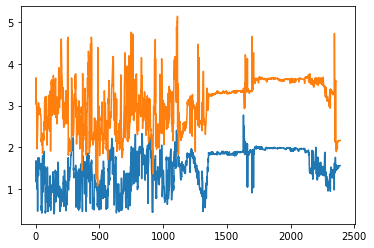